```{include} ../math-definitions.md
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

from statsmodels.tsa.x13 import x13_arima_analysis

x13path = "."

# Ajuste estacional


## Ajuste estacional o extracción de señales

Estos métodos surgieron a mitad del siglo XX para resolver dos problemas:

1. Remover la tendencia de una serie, con el fin de estudiar apropiadamente su autocorrelación.
2. Separar las variaciones estacionales de los demás componentes de las series.

Al inicio, se utilizaban métodos determiní­sticos, pero luego se fueron abandonando en favor de métodos empíricos basados en promedios móviles


## ¿Para qué ajustar una serie por estacionalidad?

El objetivo de lo métodos de ajuste estacional es extraer una señal clara de $y_t$, que permita identificar con facilidad la verdadera evolución de la serie

Si una serie de tiempo tiene mucho ruido (variabilidad) y un componente estacional fuerte, este ruido afectará a las variaciones inter-periodos o a las variaciones interanuales.

El ajuste estacional permite hacer comparaciones de un período respecto al anterior, removiendo el ruido que introduciría la presencia de la estacionalidad.


## Componentes de las series

Tendencia (T)
:   Es un movimiento de larga duración que se mantiene durante todo el período de observación.

Movimientos cíclicos (C)
:   Son oscilaciones alrededor de la tendencia producidos por periodos alternativos de prosperidad y depresión.

Variación estacional (S)
:   Son los movimientos que se producen dentro del año y que se repiten de un año a otro.

Movimientos irregulares ($\epsilon$)
:   Son las oscilaciones erráticas o accidentales que obedecen a variadas causas. No siguen ningún patrón específico de comportamiento y por tanto son impredecibles.


## Descomposición multiplicativa

\begin{equation*}
y_t = T_t \times C_t \times S_t \times \epsilon_t
\end{equation*}

Se utiliza cuando se observa que la amplitud del componente estacional varía en forma proporcional al valor de la tendencia.

En este caso el componente estacional se expresa como un índice y se interpreta como una diferencia relativa. Lo mismo ocurre para el componente irregular.

La tendencia siempre se mide en las mismas unidades que $Y_t$


## Descomposición aditiva

\begin{equation*}
y_t = T_t + C_t + S_t + \epsilon_t
\end{equation*}

Se utiliza cuando el componente estacional permanece constante, aún si existen cambios en el nivel de tendencia.

En este caso el componente estacional se expresa en las mismas unidades que $Y_t$, al igual que ocurre con el componente irregular.

La tendencia siempre se mide en las mismas unidades que $Y_t$


##  Serie desestacionalizada

Se obtiene cuando a la serie original se le elimina el componente estacional:
\begin{equation*}
y_t^{s.a.} = \frac{T_t \times C_t \times S_t \times \epsilon_t}{S_t} = T_t \times C_t \times \epsilon_t
\end{equation*}

## Serie tendencia-ciclo

Se obtiene cuando se elimina el componente estacional y el irregular de la serie original:
\begin{equation*}
y_t^{t.c.} = \frac{T_t \times C_t \times S_t \times \epsilon_t}{S_t\times \epsilon_t} = T_t \times C_t
\end{equation*}


## Métodos actuales para la estimación de componentes

### Basados en medias móviles

- Son empíricos
- La estimación de los componentes es local a través de promedio móviles centrados de distintos tamaños
- Las revisiones están sujetas a la bondad del pronóstico.

### Basados en modelos

- Proveen medidas de bondad de ajuste sobre la estimación de los componentes.
- Permite obtener pronósticos de los componentes.
- Minimiza las revisiones.
- Minimiza el riesgo de inducción de propiedades espurias.

## Línea de tiempo: programas de ajuste estacional

1967
:   X11, filtros ad-hoc, Julius Shiskin, US Bureau of the Census

1980
:   X-11 ARIMA, Statistics Canada

1997
:   X-12 ARIMA, US Bureau  of Census

2012
:   [X-13 ARIMA-SEATS, US Bureau of Census](http://www.census.gov/srd/www/winx13/index.html)

---


1992
:   TRAMO y SEATS (prueba), métodos estocásticos

1998
:   TRAMO y SEATS, Banco de España

2001
:   TSW, Banco de España

2012
:   [JDEMETRA+ Eurostat](https://ec.europa.eu/eurostat/cros/content/software-jdemetra_en)

2014
: TSW+, Banco de España




{{ empieza_ejemplo }} Descomposición de la serie pasajeros extranjeros en SJO, usando X13 {{ fin_titulo_ejemplo }}

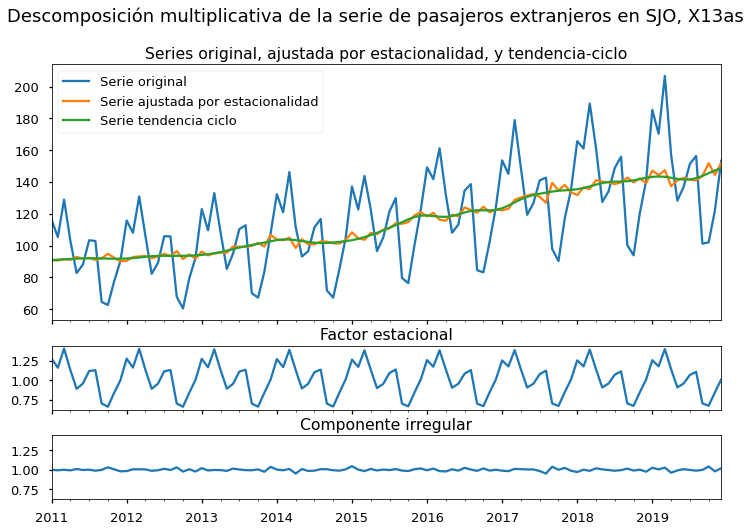

In [2]:
# read data from previous example
sjodatos =pd.read_pickle("datos/SJO-pasajeros.pickle")

extranjeros = pd.DataFrame(np.log(sjodatos['extranjeros'].values),
                      index=pd.period_range('2011-01', '2019-12', freq='M'))

def X13ARIMA(serie, show=False):

    res = x13_arima_analysis(serie, x12path=x13path, log=False)
    if show:
        print(res.results)
    temp = pd.concat([res.__getattribute__(componente) for componente in ['observed','seasadj','trend','irregular']], axis=1)
    temp.columns = ['Serie original','Serie ajustada por estacionalidad','Serie tendencia ciclo','Componente irregular']
    return temp

componentes = X13ARIMA(extranjeros, False)


fig = plt.figure(figsize=[12,8])
gs = plt.GridSpec(3,1,figure=fig, height_ratios=[4,1,1])
ax0 = fig.add_subplot(gs[0])
np.exp(componentes.iloc[:,:3]).plot(ax=ax0)

ax1 = fig.add_subplot(gs[1],sharex=ax0)
sfact = componentes['Serie original'] - componentes['Serie ajustada por estacionalidad']
np.exp(sfact).plot(ax=ax1)


ax2 = fig.add_subplot(gs[2],sharex=ax0, sharey=ax1)
np.exp(componentes['Componente irregular']).plot(ax=ax2)

ax0.set(title='Series original, ajustada por estacionalidad, y tendencia-ciclo')
ax1.set(title='Factor estacional')
ax2.set(title='Componente irregular')
fig.suptitle('Descomposición multiplicativa de la serie de pasajeros extranjeros en SJO, X13as', size=18);

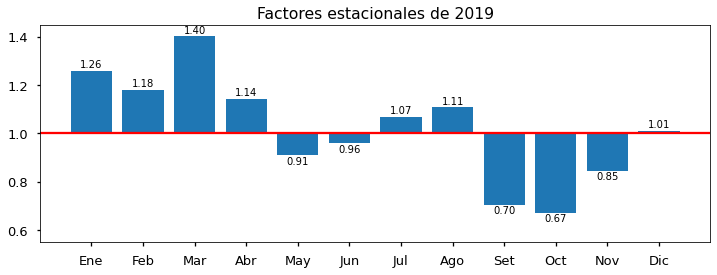

In [3]:
mesescorto = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
         'Jul', 'Ago', 'Set', 'Oct', 'Nov', 'Dic']


factores2019 = np.exp(sfact['2019':'2019'])
etiq = [f'{ff:.2f}' for ff in factores2019]
fig, ax = plt.subplots(figsize=[12,4])

ax.bar(mesescorto, factores2019-1)
ax.set(yticks=np.array([0.6,0.8,1.0,1.2,1.4])-1,
       yticklabels = ['0.6','0.8','1.0','1.2','1.4'],
       ylim=[-0.45,0.45])

ax.grid(False)
ax.axhline(0, color='red')

for mes, ff, tx in zip(range(12), factores2019.values, etiq):
    offs = -1.025 if ff<1 else -0.975
    ax.annotate(tx, (mes,ff+offs),ha='center', va='center')

ax.set(title='Factores estacionales de 2019');

- La temporada “alta” ocurre entre enero y abril.
- En marzo, el tráfico de pasajeros es 40% mayor que el valor de tendencia-ciclo.
- La temporada “baja” es entre septiembre y noviembre.
- En octubre, el tráfico de pasajeros es 33% menor que el valor de tendencia-ciclo.

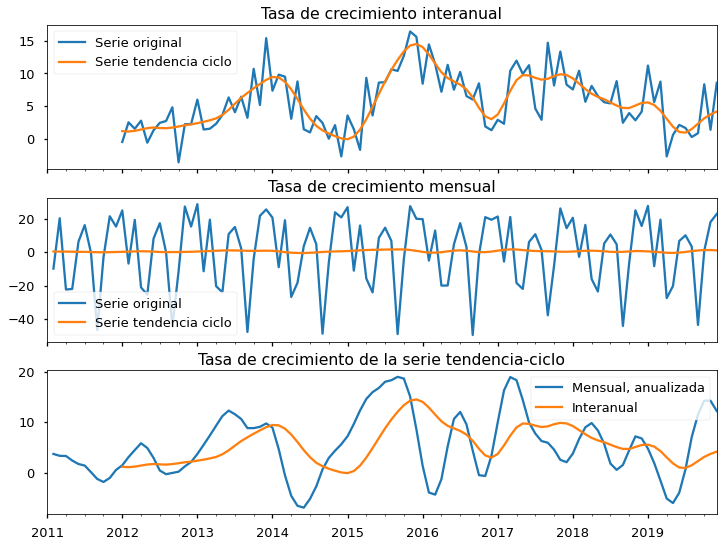

In [4]:
fig, axs = plt.subplots(3,1,figsize=[12,9], sharex=True)

(100 * componentes[['Serie original','Serie tendencia ciclo']].diff(12)).plot(ax=axs[0])

(100 * componentes[['Serie original','Serie tendencia ciclo']].diff()).plot(ax=axs[1])

(100*((componentes[['Serie tendencia ciclo']].diff())*12)).plot(ax=axs[2])
(100 * componentes[['Serie tendencia ciclo']].diff(12)).plot(ax=axs[2])


axs[0].set(title='Tasa de crecimiento interanual')
axs[1].set(title='Tasa de crecimiento mensual')
axs[2].set(title='Tasa de crecimiento de la serie tendencia-ciclo')
axs[2].legend(['Mensual, anualizada', 'Interanual'])

for ax in axs:
    ax.grid(False)

La tasa de crecimiento interanual no tiene el ruido que presenta la tasa de crecimiento interanual de la serie original.

Dado el fuerte componente estacional, la tasa de crecimiento mensual de la serie original es un pobre indicador del estado de la actividad.
Al realizar cálculos con la serie tendencia ciclo encontramos:

- la tasa de crecimiento interanual es de magnitud similar a la tasa de crecimiento mensual anualizada.
- la tasa interanual presenta un desfase respecto a la mensual anualizada.
este desfase se debe a que la interanual es una media móvil de la mensual y sus últimos 11 rezagos.
{{ termina_ejemplo }}